# PCA 


## Imports / Config

Import the required packages and configure the plotting:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pandas_plink import read_plink
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import pandas as pd

from sklearn.preprocessing import scale
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import statsmodels.api as sm

plt.style.use('../data/whitegrid.mplstyle')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Dark2.colors)

## Read data

Read the processed plink file:

In [2]:
(bim, fam, G) = read_plink("../data/preprocessed/wolvesadmix/wolvesadmix")

Mapping files: 100%|██████████| 3/3 [00:00<00:00, 36.01it/s]


Load the geographic coordinates:

In [3]:
X = np.loadtxt("../data/preprocessed/wolvesadmix/wolvesadmix.coord")

Setup the meta data:

In [4]:
fam_path = "../data/preprocessed/wolvesadmix/wolvesadmix.fam"
id_df = pd.read_table(fam_path, sep=" ", header=None).iloc[:, 1:2]
id_df.columns = ["Sample"]
id_df["idx"] = id_df.index.tolist()
id_df.head()

meta_path = "../data/raw/wolves/EnvironmentalData_6pops_94indiv.xlsx"
samp_df = pd.read_excel(meta_path)
print(samp_df.shape)

(94, 16)


/project2/jnovembre/jhmarcus/src/miniconda3/envs/feems_analysis_e/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


Join to make sure the meta data matches the row order of the fam file:

In [5]:
meta_df = id_df.merge(samp_df, how="inner")
meta_df.head()

,Sample,idx,Ecotype_k6_50%,X(Longitude),Y(Latitude),BIO1,BIO2,BIO4,BIO5,BIO6,BIO12,BIO15,BIO19,LC,NDVIM,SRTM,TREE
0,11226.CEL,0,Pop_2_BorealForest,-94.450000,49.810000,23,97,13047,253,-229,610,47,76,8,7403,349,36
1,11228.CEL,1,Pop_6_AtlanticForest,-88.110000,49.080000,15,115,11408,233,-228,784,29,142,5,8222,234,51
2,11232_CLU_NQUE-I,2,Pop_6_AtlanticForest,-72.012857,58.756188,-69,75,11831,130,-286,483,39,70,7,6450,264,5
3,11234_CLU_NQUE-I,3,Pop_6_AtlanticForest,-71.981011,58.601851,-66,76,11867,135,-284,477,40,70,7,6141,200,9
4,2042_CLU_CANADA-FBG,4,Pop_2_BorealForest,-114.833000,60.583000,-34,102,14259,207,-299,335,39,56,7,7595,194,26


Rename the ecotypes to something plottable

In [6]:
ecotypes_old = meta_df["Ecotype_k6_50%"].unique().tolist()
ecotypes_new =  list(map(lambda x: x.split("_")[2], ecotypes_old))
ecotype_dict = dict(zip(ecotypes_old, ecotypes_new))
meta_df["ecotype"] = meta_df["Ecotype_k6_50%"].apply(lambda x: ecotype_dict[x])
meta_df.head()

,Sample,idx,Ecotype_k6_50%,X(Longitude),Y(Latitude),BIO1,BIO2,BIO4,BIO5,BIO6,BIO12,BIO15,BIO19,LC,NDVIM,SRTM,TREE,ecotype
0,11226.CEL,0,Pop_2_BorealForest,-94.450000,49.810000,23,97,13047,253,-229,610,47,76,8,7403,349,36,BorealForest
1,11228.CEL,1,Pop_6_AtlanticForest,-88.110000,49.080000,15,115,11408,233,-228,784,29,142,5,8222,234,51,AtlanticForest
2,11232_CLU_NQUE-I,2,Pop_6_AtlanticForest,-72.012857,58.756188,-69,75,11831,130,-286,483,39,70,7,6450,264,5,AtlanticForest
3,11234_CLU_NQUE-I,3,Pop_6_AtlanticForest,-71.981011,58.601851,-66,76,11867,135,-284,477,40,70,7,6141,200,9,AtlanticForest
4,2042_CLU_CANADA-FBG,4,Pop_2_BorealForest,-114.833000,60.583000,-34,102,14259,207,-299,335,39,56,7,7595,194,26,BorealForest


## Process data

Switch counted allele:

In [7]:
Y = 2 - np.array(G).T
n, p = Y.shape

print(n, p)

111 17729


Impute the missing data using the SNP mean:

In [8]:
# mean impute missing data
imp = SimpleImputer(missing_values=np.nan, strategy="mean")
Y_imp = imp.fit_transform(Y[meta_df["idx"].tolist(), :])

Compute the normalized genotype matrix:

In [9]:
Z = scale(Y_imp)

## Viz: PCA

Run PCA:

In [10]:
K = 50
pca = PCA(n_components=K)
pc_df = pd.DataFrame(pca.fit_transform(Z))
pc_df.columns = ["PC{}".format(k+1) for k in range(K)]
meta_grp_df = pd.concat([meta_df, pc_df], axis=1).groupby("ecotype")
meta_pc_df = pd.concat([meta_df, pc_df], axis=1)

Viz:

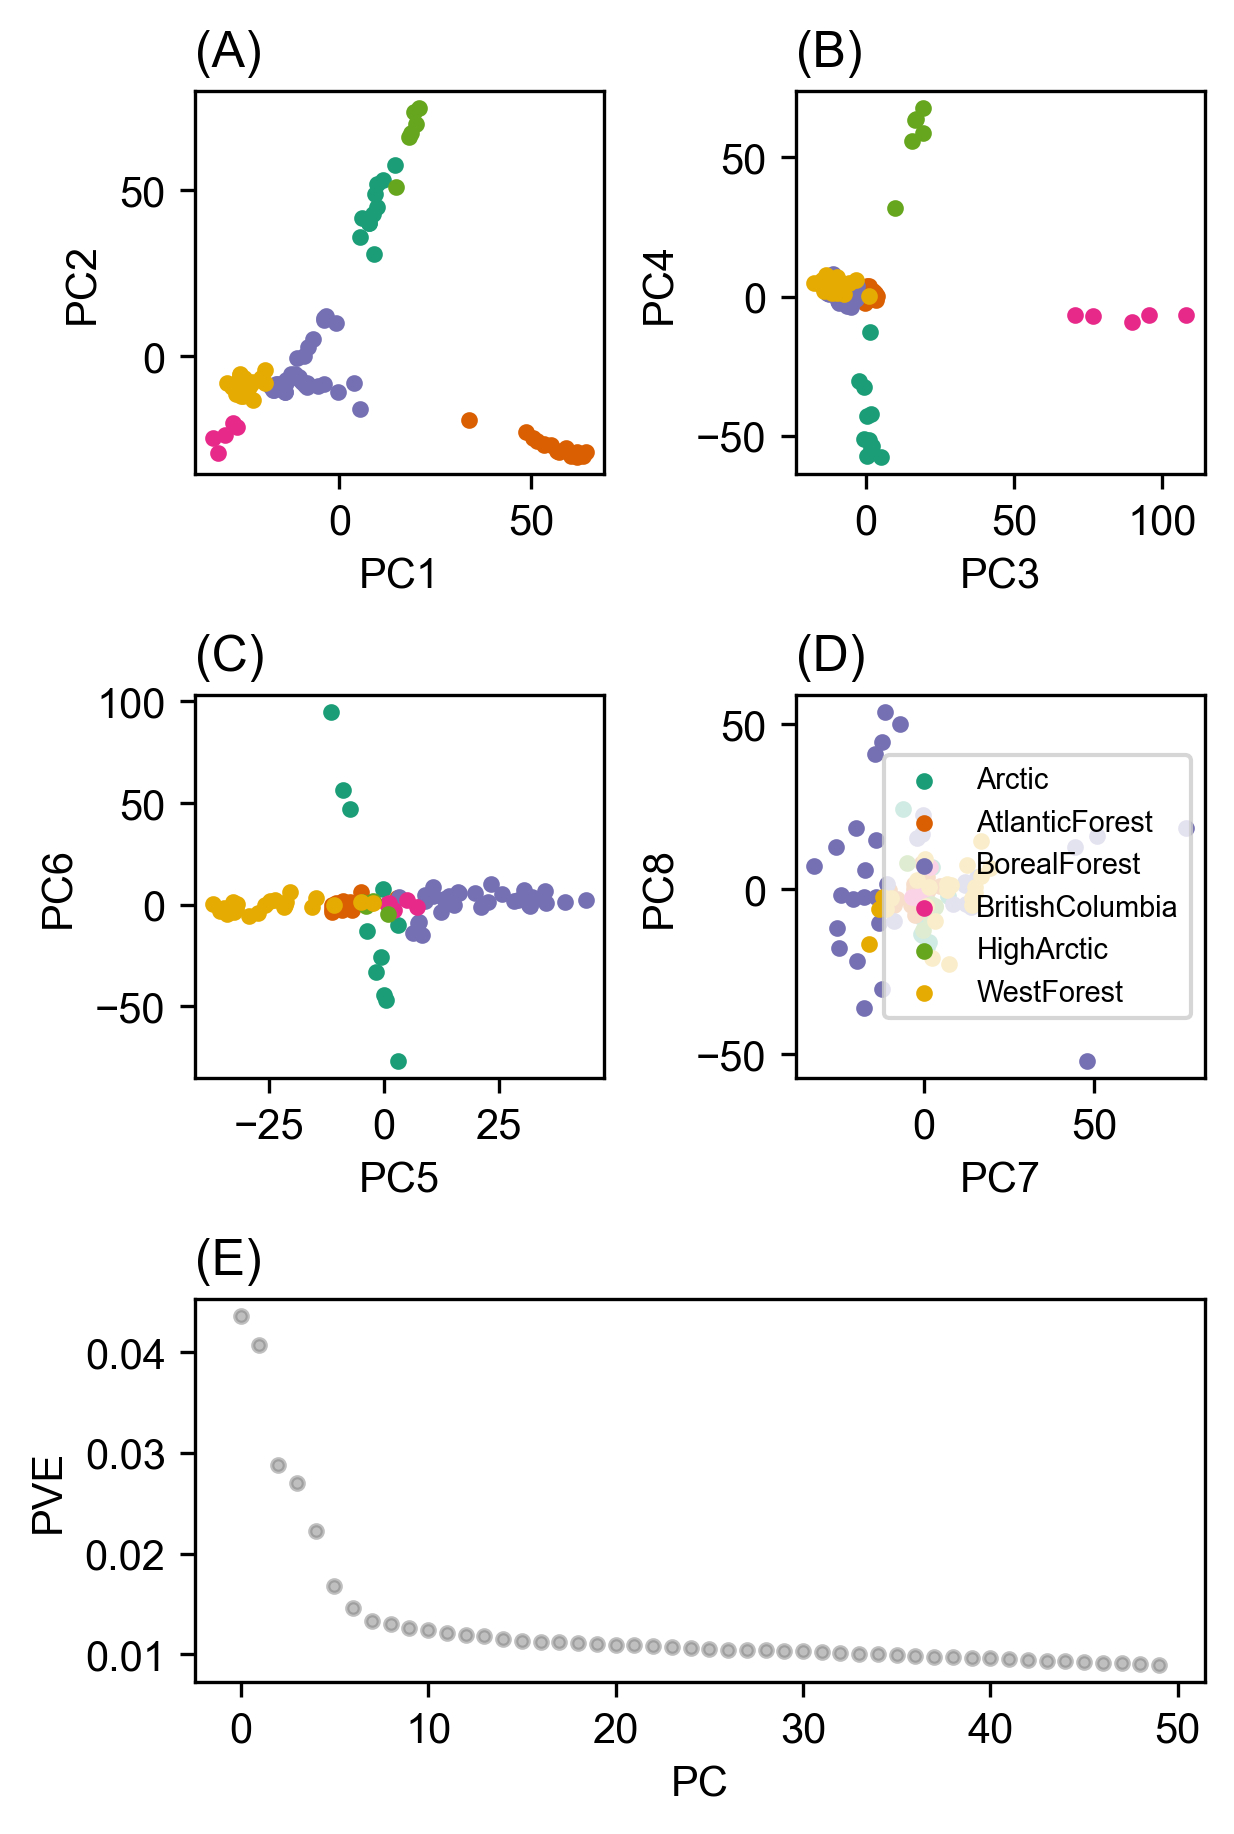

In [12]:
fig = plt.figure(constrained_layout=True, dpi=300, figsize=(4,6))
spec = gridspec.GridSpec(ncols=2, nrows=3, figure=fig)

# PC1 vs PC2
f_ax1 = fig.add_subplot(spec[0, 0])
plt.title("(A)", loc="left")

for pop, group in meta_grp_df:
    plt.scatter(group["PC1"], group["PC2"], marker=".", label=pop)
plt.xlabel("PC1")
plt.ylabel("PC2")

# PC3 vs PC4
f_ax2 = fig.add_subplot(spec[0, 1])
plt.title("(B)", loc="left")

for pop, group in meta_grp_df:
    plt.scatter(group["PC3"], group["PC4"], marker=".", label=pop)
plt.xlabel("PC3")
plt.ylabel("PC4")

# PC5 vs PC6
f_ax3 = fig.add_subplot(spec[1, 0])
plt.title("(C)", loc="left")

for pop, group in meta_grp_df:
    plt.scatter(group["PC5"], group["PC6"], marker=".", label=pop)
plt.xlabel("PC5")
plt.ylabel("PC6")

# PC7 vs PC8
f_ax4 = fig.add_subplot(spec[1, 1])
plt.title("(D)", loc="left")

for pop, group in meta_grp_df:
    plt.scatter(group["PC7"], group["PC8"], marker=".", label=pop)
plt.xlabel("PC7")
plt.ylabel("PC8")
plt.legend(fontsize = 'x-small')

# scree plot
f_ax5 = fig.add_subplot(spec[2, :])
plt.title("(E)", loc="left")

plt.plot(pca.explained_variance_ratio_, ".", color="gray", alpha=.5)
plt.xlabel("PC")
plt.ylabel("PVE")

fig.savefig(
    "../output/figures/supp-figure-7-pca.pdf", bbox_inches="tight"
)

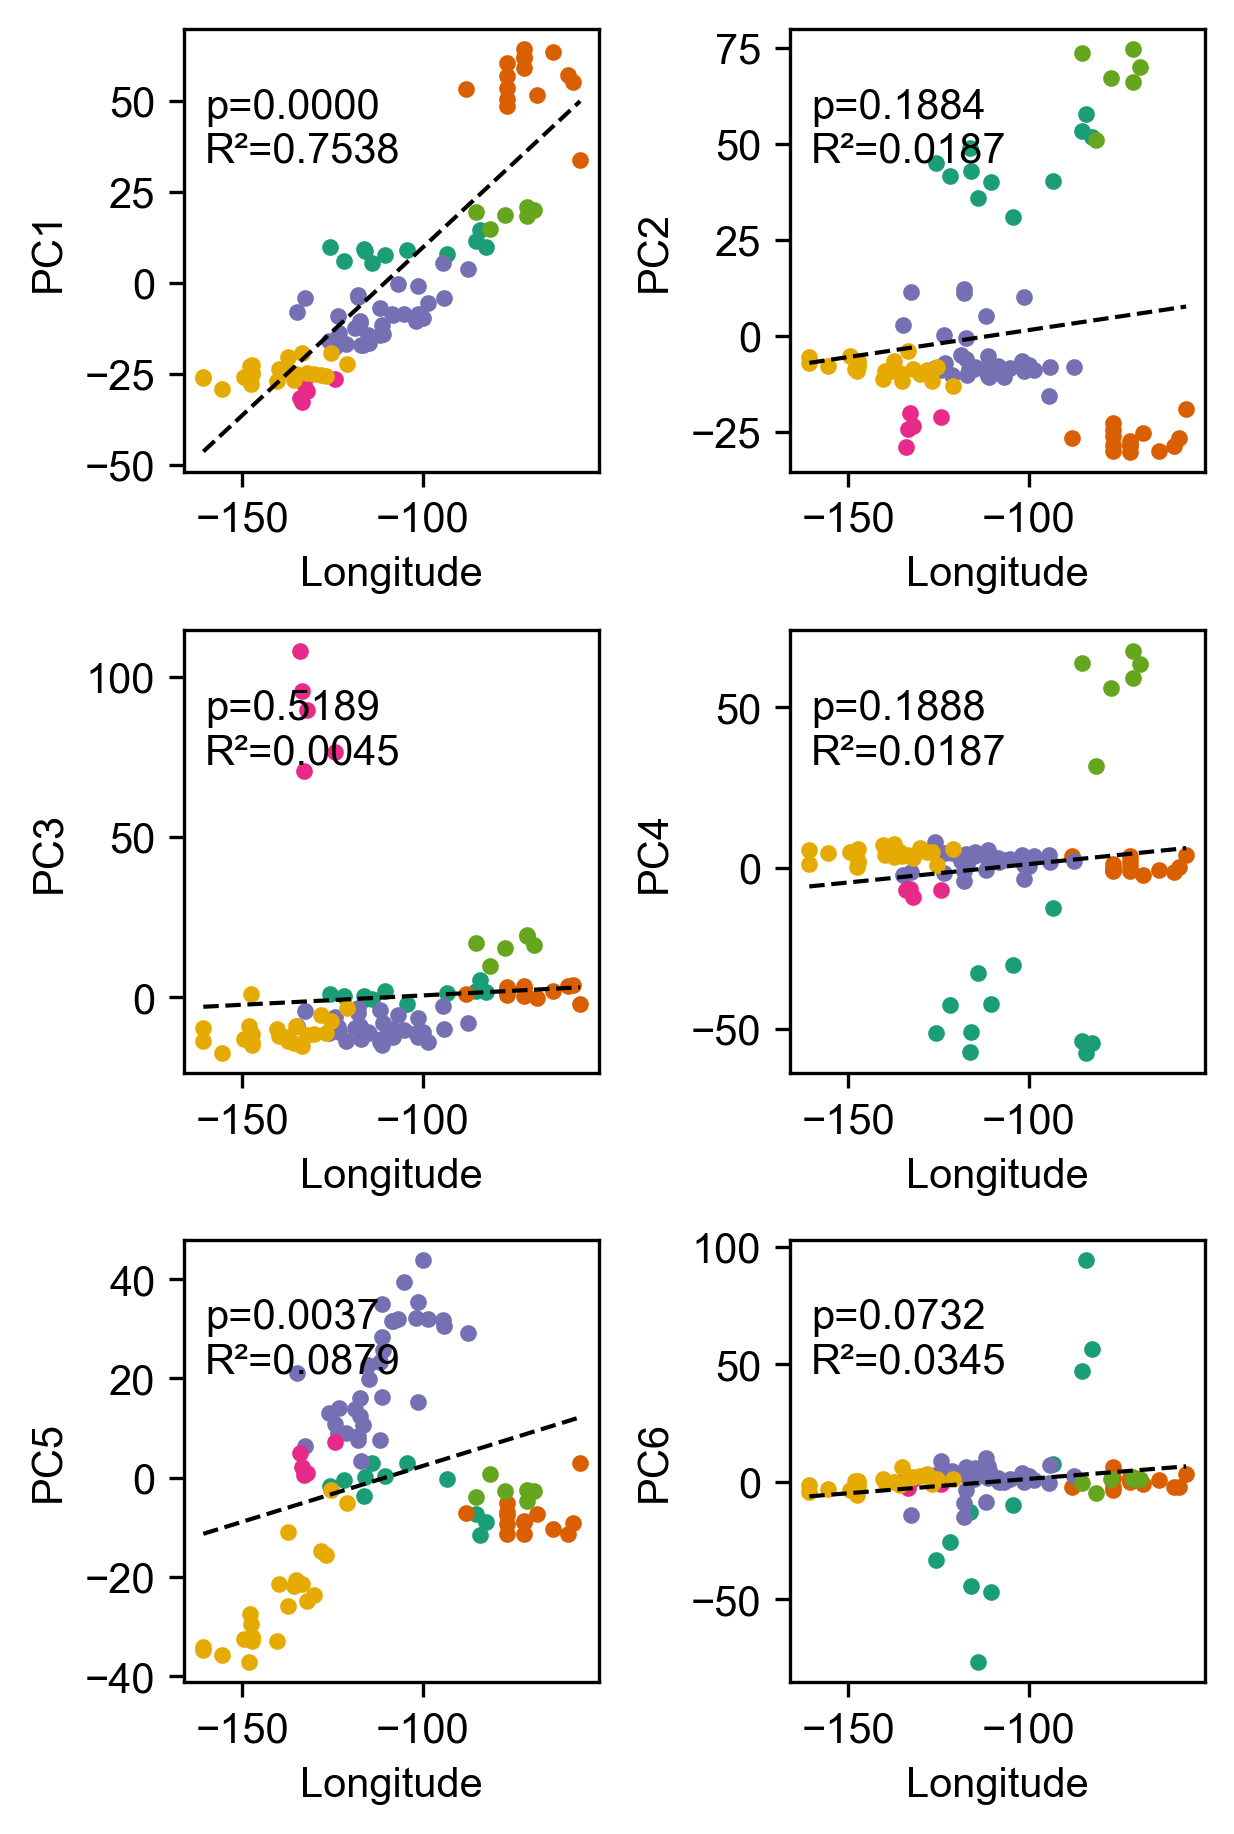

In [14]:
fig = plt.figure(constrained_layout=True, dpi=300, figsize=(4,6))
spec = gridspec.GridSpec(ncols=2, nrows=3, figure=fig)

ax_00 = fig.add_subplot(spec[0, 0])
for pop, group in meta_grp_df:
    ax_00.scatter(group["X(Longitude)"], group["PC1"], marker=".", label=pop)
X = sm.add_constant(meta_pc_df["X(Longitude)"])
y = meta_pc_df["PC1"]
mod = sm.OLS(y, X)
res = mod.fit()
muhat, betahat = res.params
x_ = np.linspace(np.min(X["X(Longitude)"]), np.max(X["X(Longitude)"]), 20)
ax_00.plot(x_, muhat + betahat * x_, zorder=2, color="black", linestyle='--', linewidth=1)
ax_00.annotate("p={:.4f}\nR²={:.4f}".format(res.pvalues[1], res.rsquared), xy=(0.05, 0.7), xycoords="axes fraction")
ax_00.set_xlabel("Longitude")
ax_00.set_ylabel("PC1")


ax_01 = fig.add_subplot(spec[0, 1])
for pop, group in meta_grp_df:
    ax_01.scatter(group["X(Longitude)"], group["PC2"], marker=".", label=pop)
X = sm.add_constant(meta_pc_df["X(Longitude)"])
y = meta_pc_df["PC2"]
mod = sm.OLS(y, X)
res = mod.fit()
muhat, betahat = res.params
x_ = np.linspace(np.min(X["X(Longitude)"]), np.max(X["X(Longitude)"]), 20)
ax_01.plot(x_, muhat + betahat * x_, zorder=2, color="black", linestyle='--', linewidth=1)
ax_01.annotate("p={:.4f}\nR²={:.4f}".format(res.pvalues[1], res.rsquared), xy=(0.05, 0.7), xycoords="axes fraction")
ax_01.set_xlabel("Longitude")
ax_01.set_ylabel("PC2")

ax_10 = fig.add_subplot(spec[1, 0])
for pop, group in meta_grp_df:
    ax_10.scatter(group["X(Longitude)"], group["PC3"], marker=".", label=pop)
X = sm.add_constant(meta_pc_df["X(Longitude)"])
y = meta_pc_df["PC3"]
mod = sm.OLS(y, X)
res = mod.fit()
muhat, betahat = res.params
x_ = np.linspace(np.min(X["X(Longitude)"]), np.max(X["X(Longitude)"]), 20)
ax_10.plot(x_, muhat + betahat * x_, zorder=2, color="black", linestyle='--', linewidth=1)
ax_10.annotate("p={:.4f}\nR²={:.4f}".format(res.pvalues[1], res.rsquared), xy=(0.05, 0.7), xycoords="axes fraction")
ax_10.set_xlabel("Longitude")
ax_10.set_ylabel("PC3")

ax_11 = fig.add_subplot(spec[1, 1])
for pop, group in meta_grp_df:
    ax_11.scatter(group["X(Longitude)"], group["PC4"], marker=".", label=pop)
X = sm.add_constant(meta_pc_df["X(Longitude)"])
y = meta_pc_df["PC4"]
mod = sm.OLS(y, X)
res = mod.fit()
muhat, betahat = res.params
x_ = np.linspace(np.min(X["X(Longitude)"]), np.max(X["X(Longitude)"]), 20)
ax_11.plot(x_, muhat + betahat * x_, zorder=2, color="black", linestyle='--', linewidth=1)
ax_11.annotate("p={:.4f}\nR²={:.4f}".format(res.pvalues[1], res.rsquared), xy=(0.05, 0.7), xycoords="axes fraction")
ax_11.set_xlabel("Longitude")
ax_11.set_ylabel("PC4")

ax_20 = fig.add_subplot(spec[2, 0])
for pop, group in meta_grp_df:
    ax_20.scatter(group["X(Longitude)"], group["PC5"], marker=".", label=pop)
X = sm.add_constant(meta_pc_df["X(Longitude)"])
y = meta_pc_df["PC5"]
mod = sm.OLS(y, X)
res = mod.fit()
muhat, betahat = res.params
x_ = np.linspace(np.min(X["X(Longitude)"]), np.max(X["X(Longitude)"]), 20)
ax_20.plot(x_, muhat + betahat * x_, zorder=2, color="black", linestyle='--', linewidth=1)
ax_20.annotate("p={:.4f}\nR²={:.4f}".format(res.pvalues[1], res.rsquared), xy=(0.05, 0.7), xycoords="axes fraction")
ax_20.set_xlabel("Longitude")
ax_20.set_ylabel("PC5")

ax_21 = fig.add_subplot(spec[2, 1])
for pop, group in meta_grp_df:
    ax_21.scatter(group["X(Longitude)"], group["PC6"], marker=".", label=pop)
X = sm.add_constant(meta_pc_df["X(Longitude)"])
y = meta_pc_df["PC6"]
mod = sm.OLS(y, X)
res = mod.fit()
muhat, betahat = res.params
x_ = np.linspace(np.min(X["X(Longitude)"]), np.max(X["X(Longitude)"]), 20)
ax_21.plot(x_, muhat + betahat * x_, zorder=2, color="black", linestyle='--', linewidth=1)
ax_21.annotate("p={:.4f}\nR²={:.4f}".format(res.pvalues[1], res.rsquared), xy=(0.05, 0.7), xycoords="axes fraction")
ax_21.set_xlabel("Longitude")
ax_21.set_ylabel("PC6")

fig.savefig(
    "../output/figures/supp-figure-9-pc_vs_lon.pdf", bbox_inches="tight"
)

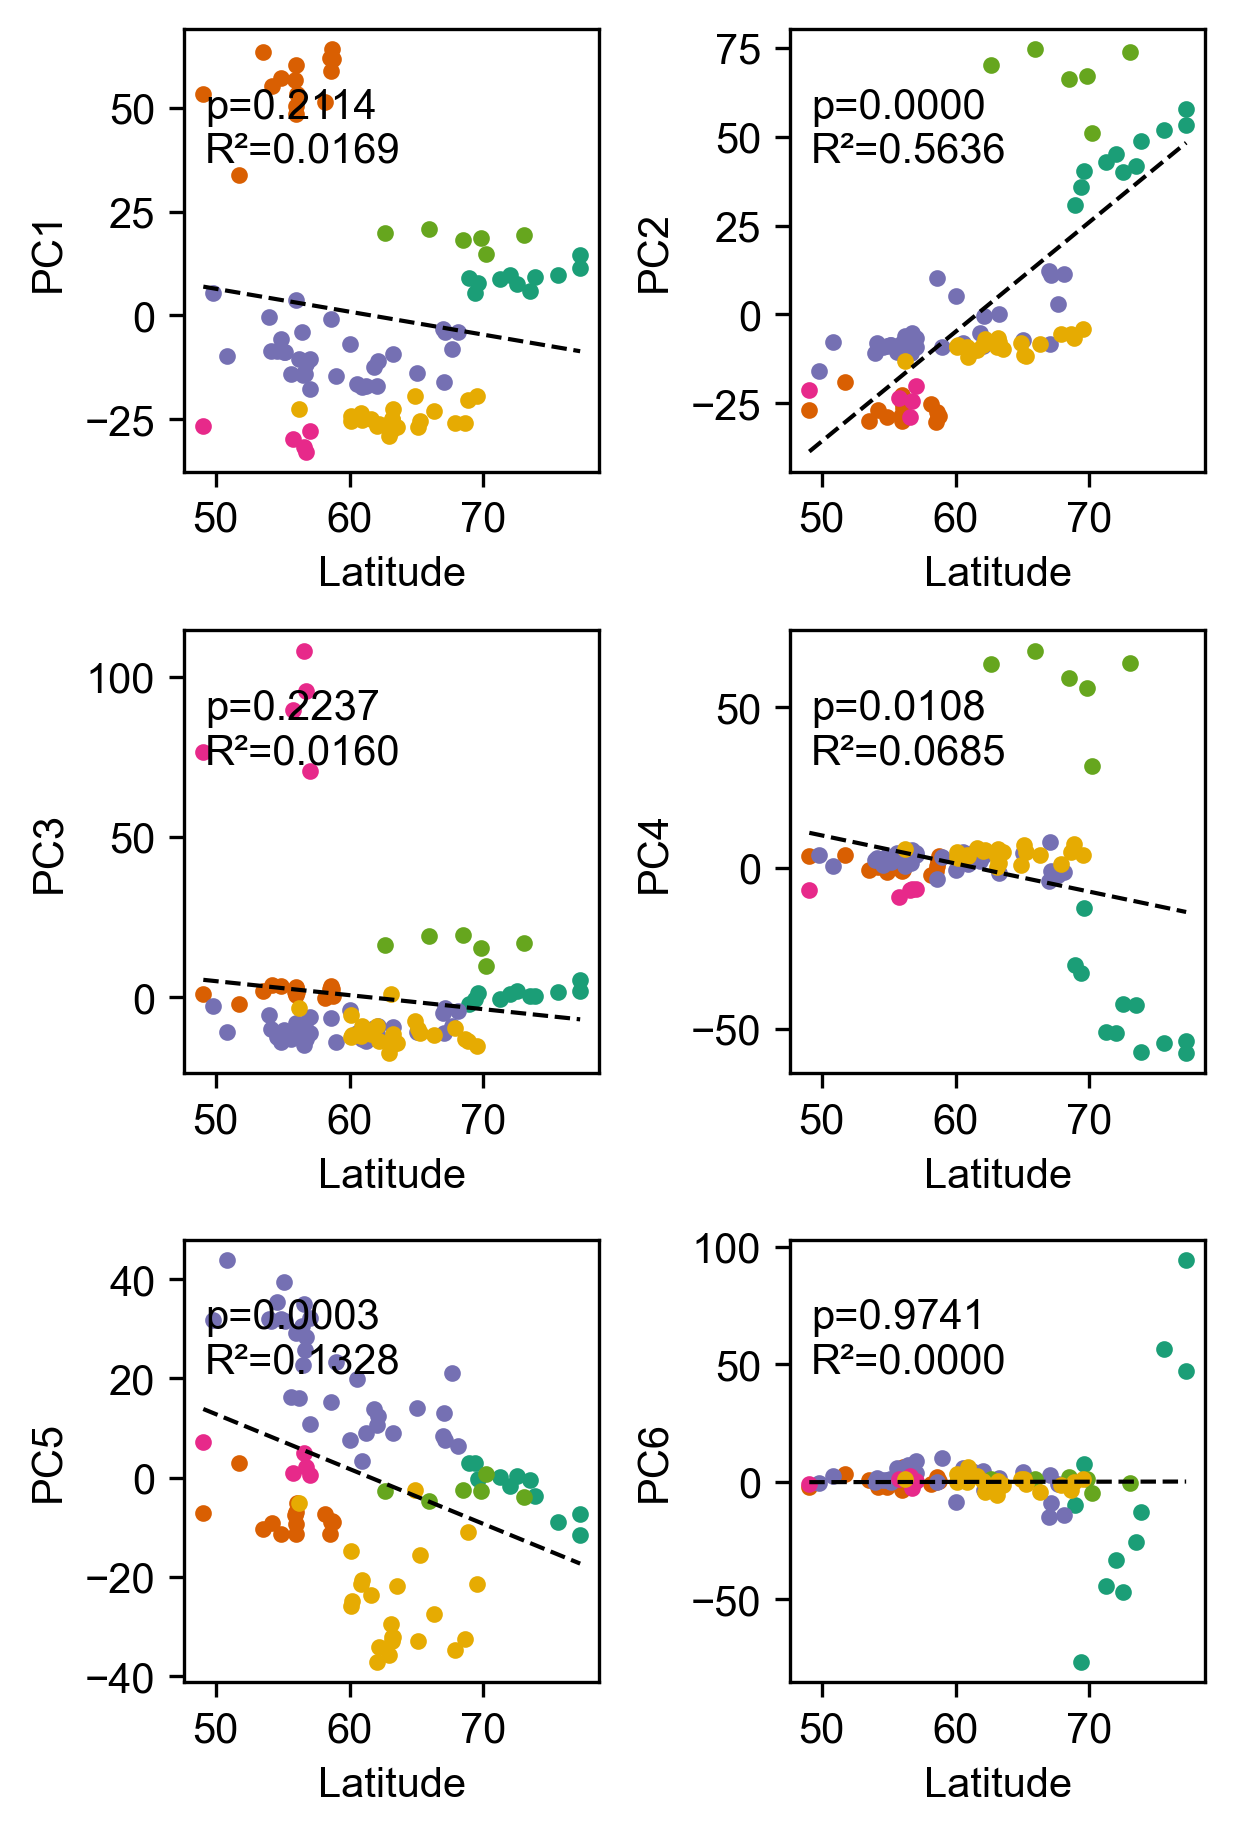

In [15]:
fig = plt.figure(constrained_layout=True, dpi=300, figsize=(4,6))
spec = gridspec.GridSpec(ncols=2, nrows=3, figure=fig)

ax_00 = fig.add_subplot(spec[0, 0])
for pop, group in meta_grp_df:
    ax_00.scatter(group["Y(Latitude)"], group["PC1"], marker=".", label=pop)
X = sm.add_constant(meta_pc_df["Y(Latitude)"])
y = meta_pc_df["PC1"]
mod = sm.OLS(y, X)
res = mod.fit()
muhat, betahat = res.params
x_ = np.linspace(np.min(X["Y(Latitude)"]), np.max(X["Y(Latitude)"]), 20)
ax_00.plot(x_, muhat + betahat * x_, zorder=2, color="black", linestyle='--', linewidth=1)
ax_00.annotate("p={:.4f}\nR²={:.4f}".format(res.pvalues[1], res.rsquared), xy=(0.05, 0.7), xycoords="axes fraction")
ax_00.set_xlabel("Latitude")
ax_00.set_ylabel("PC1")

ax_01 = fig.add_subplot(spec[0, 1])
for pop, group in meta_grp_df:
    ax_01.scatter(group["Y(Latitude)"], group["PC2"], marker=".", label=pop)
X = sm.add_constant(meta_pc_df["Y(Latitude)"])
y = meta_pc_df["PC2"]
mod = sm.OLS(y, X)
res = mod.fit()
muhat, betahat = res.params
x_ = np.linspace(np.min(X["Y(Latitude)"]), np.max(X["Y(Latitude)"]), 20)
ax_01.plot(x_, muhat + betahat * x_, zorder=2, color="black", linestyle='--', linewidth=1)
ax_01.annotate("p={:.4f}\nR²={:.4f}".format(res.pvalues[1], res.rsquared), xy=(0.05, 0.7), xycoords="axes fraction")
ax_01.set_xlabel("Latitude")
ax_01.set_ylabel("PC2")

ax_10 = fig.add_subplot(spec[1, 0])
for pop, group in meta_grp_df:
    ax_10.scatter(group["Y(Latitude)"], group["PC3"], marker=".", label=pop)
X = sm.add_constant(meta_pc_df["Y(Latitude)"])
y = meta_pc_df["PC3"]
mod = sm.OLS(y, X)
res = mod.fit()
muhat, betahat = res.params
x_ = np.linspace(np.min(X["Y(Latitude)"]), np.max(X["Y(Latitude)"]), 20)
ax_10.plot(x_, muhat + betahat * x_, zorder=2, color="black", linestyle='--', linewidth=1)
ax_10.annotate("p={:.4f}\nR²={:.4f}".format(res.pvalues[1], res.rsquared), xy=(0.05, 0.7), xycoords="axes fraction")
ax_10.set_xlabel("Latitude")
ax_10.set_ylabel("PC3")

ax_11 = fig.add_subplot(spec[1, 1])
for pop, group in meta_grp_df:
    ax_11.scatter(group["Y(Latitude)"], group["PC4"], marker=".", label=pop)
X = sm.add_constant(meta_pc_df["Y(Latitude)"])
y = meta_pc_df["PC4"]
mod = sm.OLS(y, X)
res = mod.fit()
muhat, betahat = res.params
x_ = np.linspace(np.min(X["Y(Latitude)"]), np.max(X["Y(Latitude)"]), 20)
ax_11.plot(x_, muhat + betahat * x_, zorder=2, color="black", linestyle='--', linewidth=1)
ax_11.annotate("p={:.4f}\nR²={:.4f}".format(res.pvalues[1], res.rsquared), xy=(0.05, 0.7), xycoords="axes fraction")
ax_11.set_xlabel("Latitude")
ax_11.set_ylabel("PC4")

ax_20 = fig.add_subplot(spec[2, 0])
for pop, group in meta_grp_df:
    ax_20.scatter(group["Y(Latitude)"], group["PC5"], marker=".", label=pop)
X = sm.add_constant(meta_pc_df["Y(Latitude)"])
y = meta_pc_df["PC5"]
mod = sm.OLS(y, X)
res = mod.fit()
muhat, betahat = res.params
x_ = np.linspace(np.min(X["Y(Latitude)"]), np.max(X["Y(Latitude)"]), 20)
ax_20.plot(x_, muhat + betahat * x_, zorder=2, color="black", linestyle='--', linewidth=1)
ax_20.annotate("p={:.4f}\nR²={:.4f}".format(res.pvalues[1], res.rsquared), xy=(0.05, 0.7), xycoords="axes fraction")
ax_20.set_xlabel("Latitude")
ax_20.set_ylabel("PC5")

ax_21 = fig.add_subplot(spec[2, 1])
for pop, group in meta_grp_df:
    ax_21.scatter(group["Y(Latitude)"], group["PC6"], marker=".", label=pop)
X = sm.add_constant(meta_pc_df["Y(Latitude)"])
y = meta_pc_df["PC6"]
mod = sm.OLS(y, X)
res = mod.fit()
muhat, betahat = res.params
x_ = np.linspace(np.min(X["Y(Latitude)"]), np.max(X["Y(Latitude)"]), 20)
ax_21.plot(x_, muhat + betahat * x_, zorder=2, color="black", linestyle='--', linewidth=1)
ax_21.annotate("p={:.4f}\nR²={:.4f}".format(res.pvalues[1], res.rsquared), xy=(0.05, 0.7), xycoords="axes fraction")
ax_21.set_xlabel("Latitude")
ax_21.set_ylabel("PC6")

fig.savefig(
    "../output/figures/supp-figure-8-pc_vs_lat.pdf", bbox_inches="tight"
)